In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

### EI test

[[0.01795472 0.0032797  0.00629377 0.00188088]
 [0.0032797  0.01140048 0.00206096 0.00450058]
 [0.00629377 0.00206096 0.0193845  0.00201846]
 [0.00188088 0.00450058 0.00201846 0.01147207]]
(8, 4) (8, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 1022.31it/s, 15 steps of size 3.48e-01. acc. prob=0.85]
INFO:[GP]: MCMC elapsed time: 2.60s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     18.46     48.65      4.48      0.09     28.62     29.45      0.98
_kernel_inv_length_sq[1]      9.46     28.48      2.02      0.05     12.76     32.12      1.02
_kernel_inv_length_sq[2]      3.29      4.81      1.32      0.08      6.00     19.67      1.10
_kernel_inv_length_sq[3]      5.06     11.72      0.85      0.01     10.27     47.60      1.06
        kernel_length[0]      1.21      1.18      0.91      0.09      2.40     61.96      0.98
        kernel_length[1]      1.83      2.12      1.37      0.19      3.52     31.64      1.03
        kernel_length[2]      2.14      2.37      1.32      0.44      4.96      9.37      1.21
        kernel_length[3]      3.69      6.23      1.60      0.17      7.48     19.01      1.01
            kernel_tausq      0.91      1.92      0.33      0.02      1.56     25.20      0.99
              kernel_var     10.38      8.35     

Text(0, 0.5, '$x_4$')

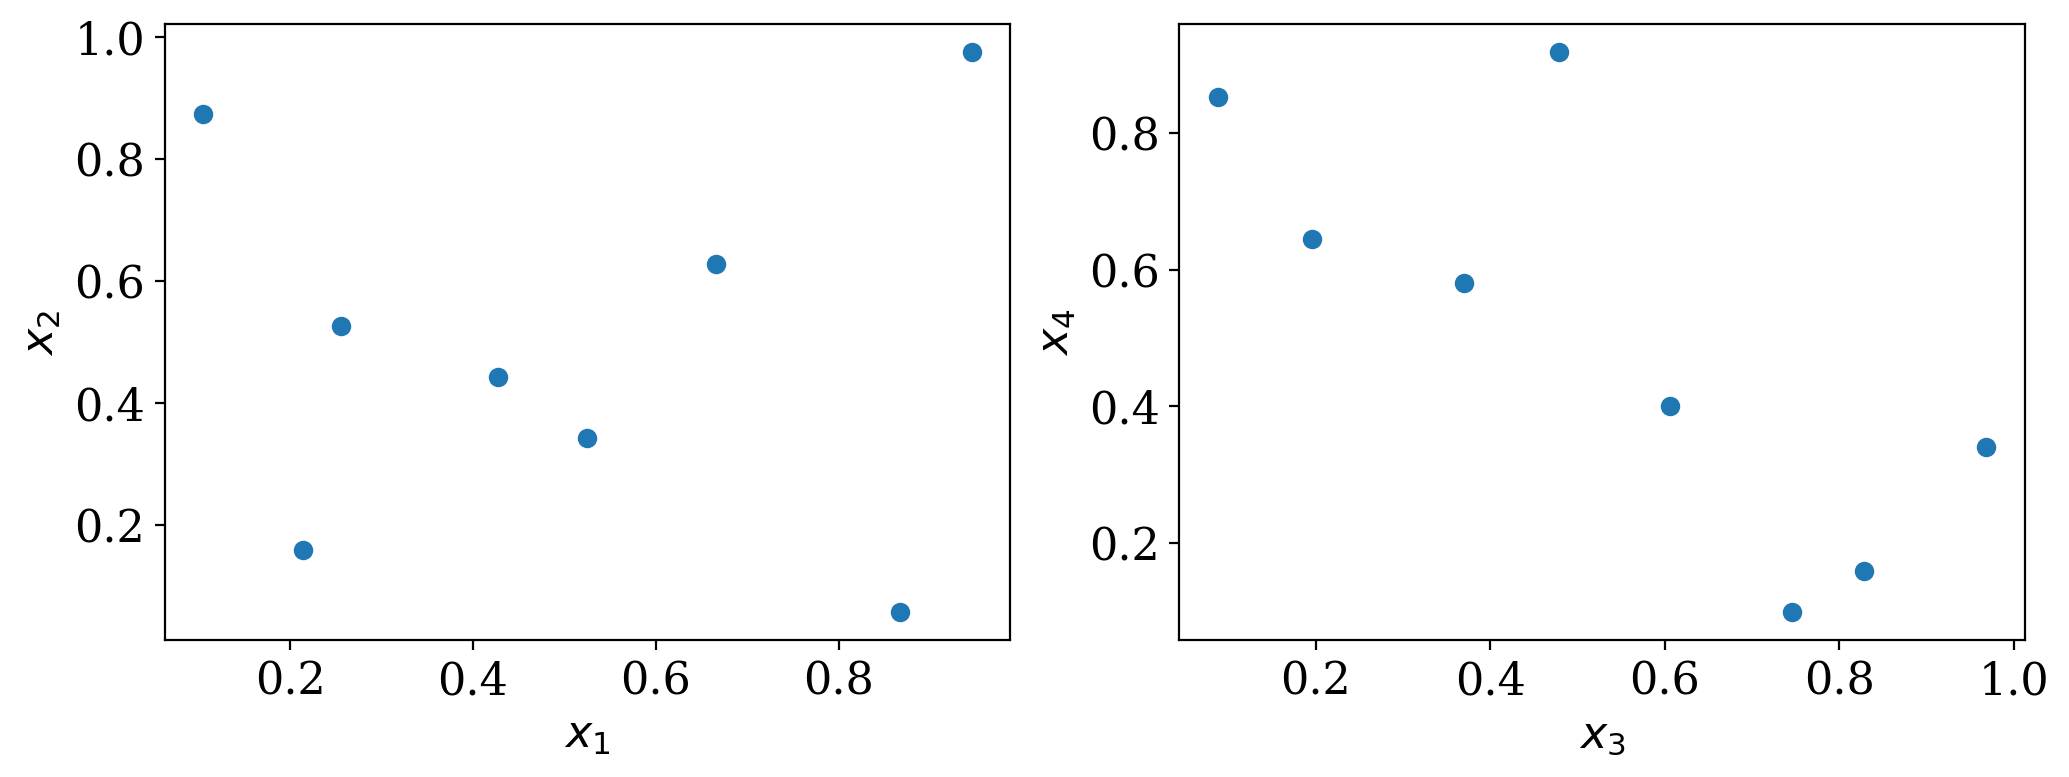

In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 8
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])[:ndim]
cov1 = 0.1*np.eye(ndim) + 0.2*np.random.uniform(0.,0.5,(ndim,ndim))
cov = 0.05*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.logpdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [3]:
nsteps = 16 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples)
    mc_points = samples[::int(size/mc_points_size),:]
    acq_func = EI(gp,gp.train_y.max()) # IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    gp = saas_fbgp(train_x,train_y,noise=1e-6)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 3.88s
INFO:[NS]: jaxns did 23076 likelihood evaluations


LogZ info :logz_mean: = -0.2489, dlogz: = 0.2514, 


INFO:[AQ]: Acquisition optimization took 5.28 s


Next point at x = [0.41177029 1.         0.09670407 0.        ] with acquisition function value = -0.3752062047976348


sample: 100%|██████████| 512/512 [00:00<00:00, 606.79it/s, 15 steps of size 2.51e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 1.30s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 2.29s
INFO:[NS]: jaxns did 24335 likelihood evaluations


LogZ info :logz_mean: = -0.3111, dlogz: = 0.2480, 


INFO:[AQ]: Acquisition optimization took 2.76 s


Next point at x = [0.4867774  0.61323599 0.81518973 0.69886551] with acquisition function value = -0.23460026342163715


sample: 100%|██████████| 512/512 [00:00<00:00, 634.09it/s, 15 steps of size 2.48e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 1.16s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 2.84s
INFO:[NS]: jaxns did 20735 likelihood evaluations


LogZ info :logz_mean: = -1.9941, dlogz: = 0.2433, 


INFO:[AQ]: Acquisition optimization took 3.13 s


Next point at x = [0.         0.43774859 0.32927369 0.34734296] with acquisition function value = -0.1785166647048336


sample: 100%|██████████| 512/512 [00:00<00:00, 597.49it/s, 15 steps of size 2.46e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 1.43s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 2.14s
INFO:[NS]: jaxns did 23913 likelihood evaluations


LogZ info :logz_mean: = -0.6371, dlogz: = 0.2512, 


INFO:[AQ]: Acquisition optimization took 2.56 s


Next point at x = [0.         0.56266473 0.51460817 1.        ] with acquisition function value = -0.20755174505594426


sample: 100%|██████████| 512/512 [00:00<00:00, 660.48it/s, 7 steps of size 4.35e-01. acc. prob=0.78] 
INFO:[GP]: MCMC elapsed time: 1.13s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 2.09s
INFO:[NS]: jaxns did 26746 likelihood evaluations


LogZ info :logz_mean: = -0.4778, dlogz: = 0.2691, 


INFO:[AQ]: Acquisition optimization took 3.47 s


Next point at x = [0.4864466  0.58567672 0.73608204 0.44817643] with acquisition function value = -0.19587565498562395


sample: 100%|██████████| 512/512 [00:00<00:00, 662.79it/s, 7 steps of size 4.35e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 1.13s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 2.22s
INFO:[NS]: jaxns did 26965 likelihood evaluations


LogZ info :logz_mean: = -0.3446, dlogz: = 0.2618, 


INFO:[AQ]: Acquisition optimization took 3.08 s


Next point at x = [1.         0.52400577 1.         0.48975   ] with acquisition function value = -0.08988936894235375


sample: 100%|██████████| 512/512 [00:00<00:00, 640.59it/s, 7 steps of size 3.86e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 1.16s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 2.72s
INFO:[NS]: jaxns did 29950 likelihood evaluations


LogZ info :logz_mean: = -0.1264, dlogz: = 0.2643, 


INFO:[AQ]: Acquisition optimization took 1.31 s


Next point at x = [0. 0. 0. 0.] with acquisition function value = -0.05128042735408716


sample: 100%|██████████| 512/512 [00:00<00:00, 623.40it/s, 7 steps of size 4.89e-01. acc. prob=0.83]
INFO:[GP]: MCMC elapsed time: 1.18s


----------------------Step 7 complete----------------------



INFO:[NS]: Nested Sampling took 2.25s
INFO:[NS]: jaxns did 30376 likelihood evaluations


LogZ info :logz_mean: = -0.6596, dlogz: = 0.2694, 


INFO:[AQ]: Acquisition optimization took 3.01 s


Next point at x = [0.45980622 0.55260276 0.5187356  0.3248428 ] with acquisition function value = -0.022828817222411077


sample: 100%|██████████| 512/512 [00:00<00:00, 640.66it/s, 15 steps of size 5.22e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 1.18s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 2.17s
INFO:[NS]: jaxns did 25964 likelihood evaluations


LogZ info :logz_mean: = -0.1043, dlogz: = 0.2663, 


INFO:[AQ]: Acquisition optimization took 0.44 s


Next point at x = [0.95391163 0.         0.98565585 0.50858057] with acquisition function value = -6.470199609079117e-07


sample: 100%|██████████| 512/512 [00:00<00:00, 585.59it/s, 15 steps of size 4.01e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.35s


----------------------Step 9 complete----------------------



INFO:[NS]: Nested Sampling took 2.12s
INFO:[NS]: jaxns did 24966 likelihood evaluations


LogZ info :logz_mean: = 0.0056, dlogz: = 0.2596, 


INFO:[AQ]: Acquisition optimization took 1.03 s


Next point at x = [1.         0.39360688 0.         0.        ] with acquisition function value = -0.03451210720045735


sample: 100%|██████████| 512/512 [00:00<00:00, 660.63it/s, 7 steps of size 6.94e-01. acc. prob=0.82]
INFO:[GP]: MCMC elapsed time: 1.19s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 2.29s
INFO:[NS]: jaxns did 28184 likelihood evaluations


LogZ info :logz_mean: = -0.2464, dlogz: = 0.2691, 


INFO:[AQ]: Acquisition optimization took 1.88 s


Next point at x = [0.         0.65315168 1.         0.        ] with acquisition function value = -0.04654939103863843


sample: 100%|██████████| 512/512 [00:00<00:00, 654.75it/s, 7 steps of size 6.74e-01. acc. prob=0.85] 
INFO:[GP]: MCMC elapsed time: 1.22s


----------------------Step 11 complete----------------------



INFO:[NS]: Nested Sampling took 2.13s
INFO:[NS]: jaxns did 28798 likelihood evaluations


LogZ info :logz_mean: = -0.0854, dlogz: = 0.2631, 


INFO:[AQ]: Acquisition optimization took 3.39 s


Next point at x = [0.49847026 0.73877418 0.58137447 0.50958341] with acquisition function value = -0.013547564585847254


sample: 100%|██████████| 512/512 [00:00<00:00, 585.90it/s, 7 steps of size 7.37e-01. acc. prob=0.85]
INFO:[GP]: MCMC elapsed time: 1.29s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 2.26s
INFO:[NS]: jaxns did 29716 likelihood evaluations


LogZ info :logz_mean: = 0.0778, dlogz: = 0.2658, 


INFO:[AQ]: Acquisition optimization took 0.47 s


Next point at x = [1.         0.         0.24569357 0.        ] with acquisition function value = -5.180766363021017e-12


sample: 100%|██████████| 512/512 [00:00<00:00, 606.08it/s, 7 steps of size 5.93e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.30s


----------------------Step 13 complete----------------------



INFO:[NS]: Nested Sampling took 2.19s
INFO:[NS]: jaxns did 30001 likelihood evaluations


LogZ info :logz_mean: = 0.0719, dlogz: = 0.2650, 


INFO:[AQ]: Acquisition optimization took 0.44 s


Next point at x = [0.         0.69462087 1.         0.52110161] with acquisition function value = -9.201749532139212e-09


sample: 100%|██████████| 512/512 [00:00<00:00, 583.23it/s, 7 steps of size 5.15e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 1.33s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 2.19s
INFO:[NS]: jaxns did 28482 likelihood evaluations


LogZ info :logz_mean: = -0.0974, dlogz: = 0.2669, 


INFO:[AQ]: Acquisition optimization took 0.43 s


Next point at x = [0.98870119 0.4342688  0.46993478 0.57532456] with acquisition function value = -2.0074859833293165e-13


sample: 100%|██████████| 512/512 [00:00<00:00, 663.35it/s, 7 steps of size 5.97e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.18s


----------------------Step 15 complete----------------------



INFO:[NS]: Nested Sampling took 2.45s
INFO:[NS]: jaxns did 28879 likelihood evaluations


LogZ info :logz_mean: = -0.0180, dlogz: = 0.2665, 


INFO:[AQ]: Acquisition optimization took 0.45 s


Next point at x = [0.         0.42629438 0.45472717 0.05229935] with acquisition function value = -1.5967969906088607e-21


sample: 100%|██████████| 512/512 [00:01<00:00, 427.92it/s, 7 steps of size 7.13e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 1.66s


----------------------Step 16 complete----------------------

BO took 96.59 s 


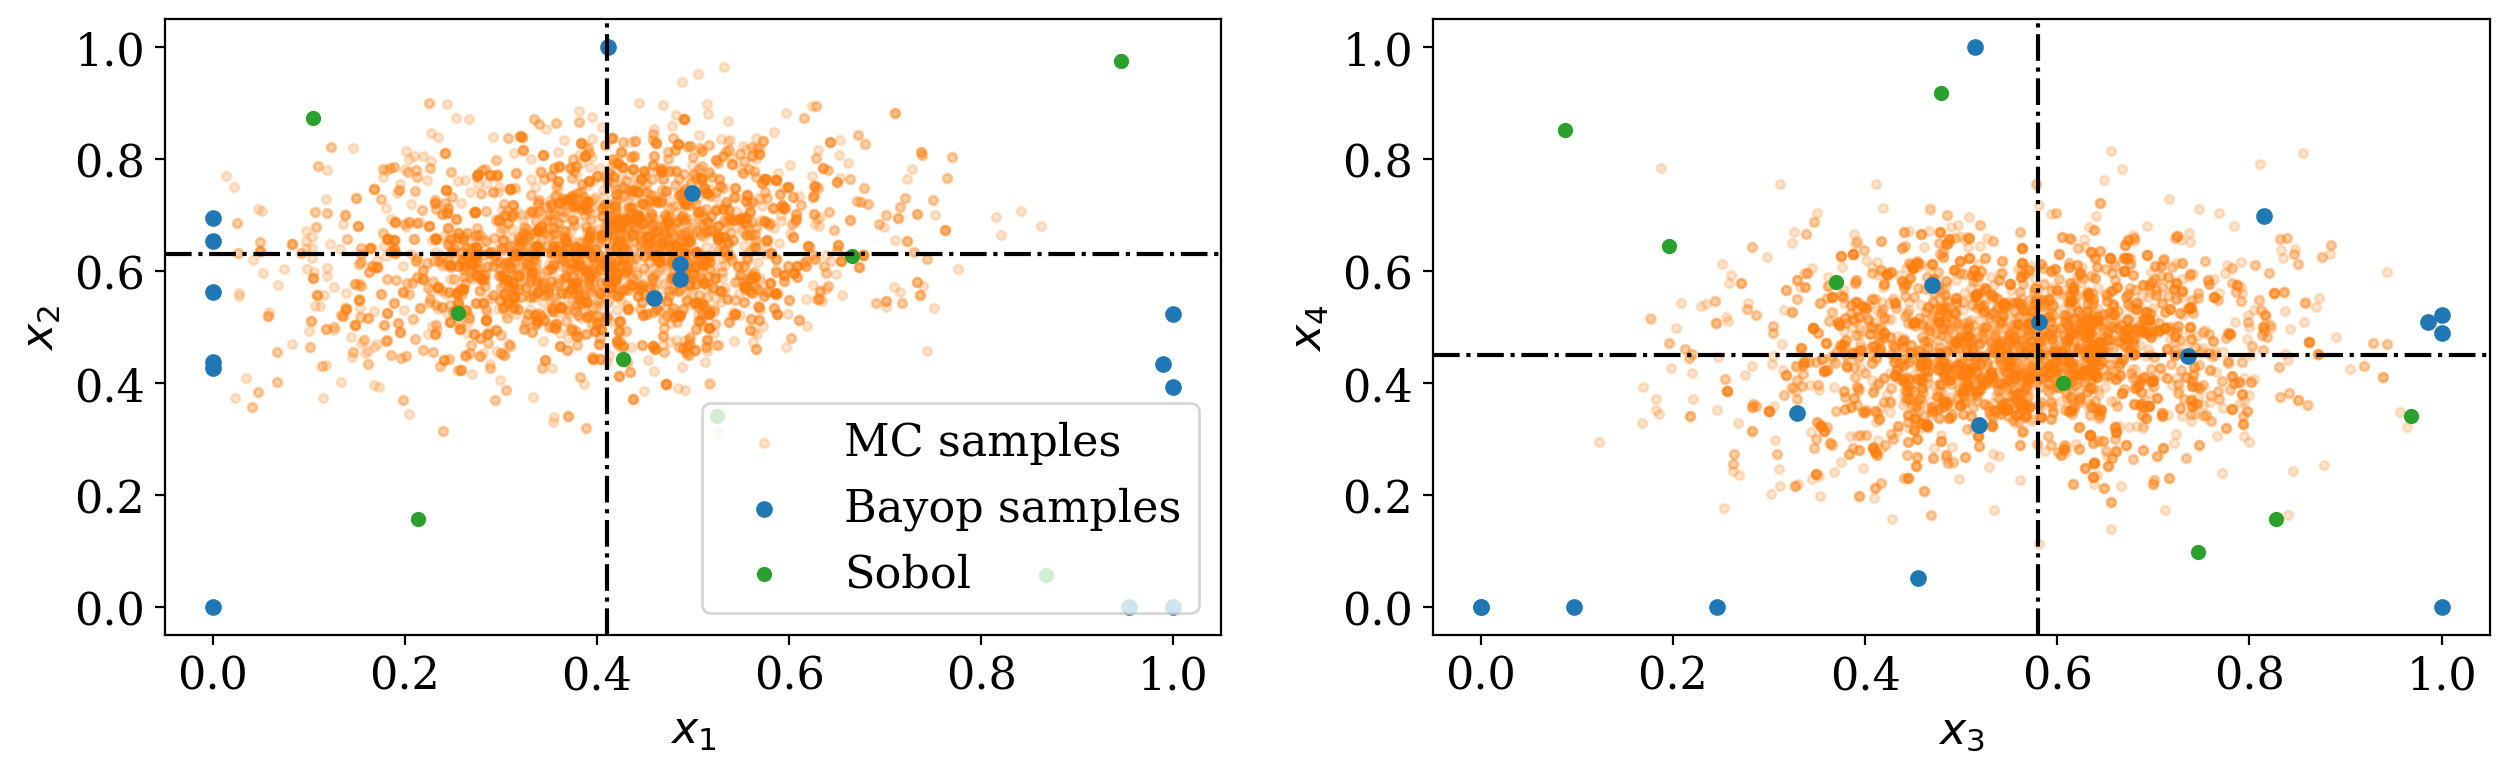

In [4]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(15,4))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    x.axvline(f_mean[2*i],ls='-.',color='k')
    x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()

In [5]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 6.97s
INFO:[NS]: jaxns did 431387 likelihood evaluations


LogZ logz_mean: 0.0165, dlogz: 0.1486, 


Removed no burn in
Removed no burn in


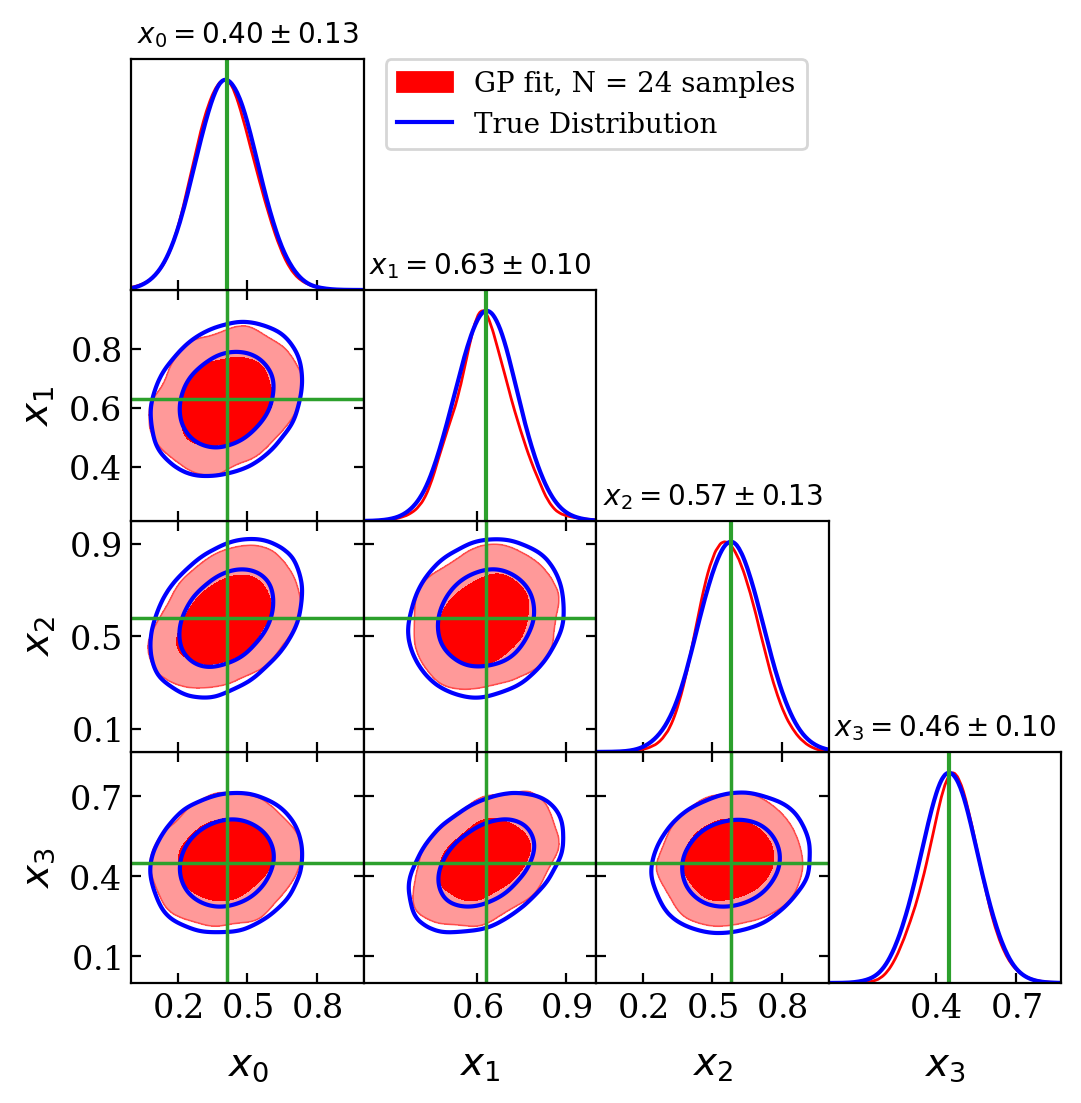

In [6]:
test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=1.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-')




### IPV test

[[0.01795472 0.0032797  0.00629377 0.00188088]
 [0.0032797  0.01140048 0.00206096 0.00450058]
 [0.00629377 0.00206096 0.0193845  0.00201846]
 [0.00188088 0.00450058 0.00201846 0.01147207]]
(8, 4) (8, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 1010.66it/s, 7 steps of size 2.96e-01. acc. prob=0.85]
INFO:[GP]: MCMC elapsed time: 1.37s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]      4.12     15.12      0.45      0.01      4.84     37.32      1.01
_kernel_inv_length_sq[1]      6.19      6.30      4.28      0.11     17.86     43.16      0.97
_kernel_inv_length_sq[2]     19.00     37.91      3.80      0.12     49.86     27.75      1.01
_kernel_inv_length_sq[3]      1.91      3.89      0.99      0.01      3.28     34.99      1.00
        kernel_length[0]      2.11      1.94      1.65      0.08      3.90     54.58      1.02
        kernel_length[1]      0.69      0.42      0.60      0.08      1.24     23.97      1.01
        kernel_length[2]      0.70      0.76      0.42      0.16      1.90     37.97      0.97
        kernel_length[3]      2.67      6.84      1.03      0.21      3.36     30.64      1.03
            kernel_tausq      2.07      3.07      0.89      0.07      4.24     14.09      1.03
              kernel_var      7.88      7.57     

Text(0, 0.5, '$x_4$')

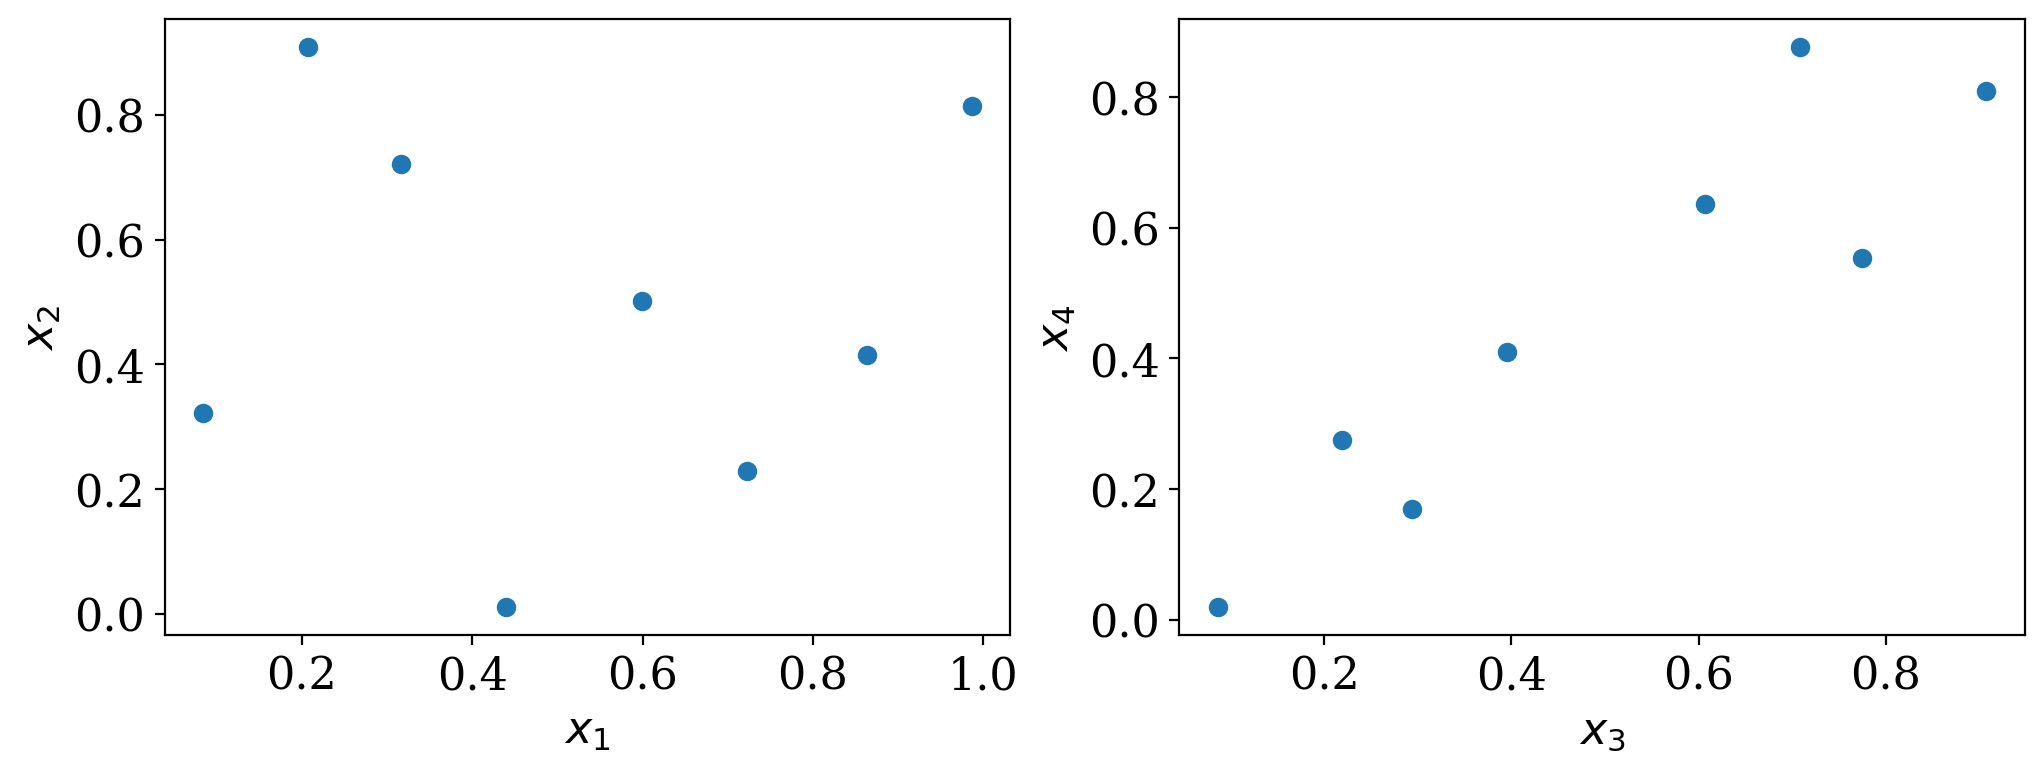

In [7]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 8
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)
f_mean = np.array([0.41,0.63,0.58,0.45])[:ndim]
cov1 = 0.1*np.eye(ndim) + 0.2*np.random.uniform(0.,0.5,(ndim,ndim))
cov = 0.05*(cov1 + np.transpose(cov1))
print(cov)

from scipy.stats import multivariate_normal

mnorm =  multivariate_normal(mean = f_mean,cov = cov)

f = lambda x: mnorm.logpdf(x).reshape(-1,1) # -0.5*np.sum((x - f_mean)**2,axis=-1,keepdims=True)/ f_std**2 

train_y = f(train_x)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(train_x[:,0],train_x[:,1])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
ax2.scatter(train_x[:,2],train_x[:,3])
ax2.set_xlabel(r'$x_3$')
ax2.set_ylabel(r'$x_4$')

In [8]:
nsteps = 16 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples)
    mc_points = samples[::int(size/mc_points_size),:]
    # print(mc_points.shape)
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)) 
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    gp.update(next_x,next_y,rng_key)
    # gp = saas_fbgp(train_x,train_y,noise=1e-6)
    # gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 2.63s
INFO:[NS]: jaxns did 27175 likelihood evaluations


LogZ info :logz_mean: = 0.4793, dlogz: = 0.2612, 


INFO:[AQ]: Acquisition optimization took 3.14 s


Next point at x = [0.08942952 0.65517057 0.5483275  0.31977057] with acquisition function value = 0.16857477235676793


sample: 100%|██████████| 384/384 [00:00<00:00, 467.50it/s, 15 steps of size 3.25e-01. acc. prob=0.85]
INFO:[GP]: MCMC elapsed time: 1.10s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 2.16s
INFO:[NS]: jaxns did 25036 likelihood evaluations


LogZ info :logz_mean: = -0.4549, dlogz: = 0.2595, 


INFO:[AQ]: Acquisition optimization took 1.59 s


Next point at x = [0.43873286 0.73418844 0.45991938 0.64665869] with acquisition function value = 0.17449419381237297


sample: 100%|██████████| 384/384 [00:00<00:00, 518.87it/s, 7 steps of size 4.11e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 0.96s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 2.02s
INFO:[NS]: jaxns did 25440 likelihood evaluations


LogZ info :logz_mean: = -0.7339, dlogz: = 0.2435, 


INFO:[AQ]: Acquisition optimization took 2.09 s


Next point at x = [0.2978378  0.66143541 0.41647817 0.80463426] with acquisition function value = 0.18850155250927506


sample: 100%|██████████| 384/384 [00:00<00:00, 421.74it/s, 31 steps of size 2.77e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.16s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 2.41s
INFO:[NS]: jaxns did 26385 likelihood evaluations


LogZ info :logz_mean: = -0.3000, dlogz: = 0.2472, 


INFO:[AQ]: Acquisition optimization took 1.51 s


Next point at x = [0.44854042 0.64755605 0.77686815 0.44889726] with acquisition function value = 0.35554416280140017


sample: 100%|██████████| 384/384 [00:00<00:00, 517.17it/s, 7 steps of size 5.13e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 0.97s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 2.59s
INFO:[NS]: jaxns did 27443 likelihood evaluations


LogZ info :logz_mean: = 0.3497, dlogz: = 0.2466, 


INFO:[AQ]: Acquisition optimization took 1.19 s


Next point at x = [0.24611952 0.72197474 0.86605294 0.49846157] with acquisition function value = 0.1272562686629813


sample: 100%|██████████| 384/384 [00:00<00:00, 436.06it/s, 15 steps of size 2.60e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.08s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 2.17s
INFO:[NS]: jaxns did 29907 likelihood evaluations


LogZ info :logz_mean: = 0.3621, dlogz: = 0.2613, 


INFO:[AQ]: Acquisition optimization took 1.44 s


Next point at x = [0.59253128 0.65730461 0.6220781  0.32695866] with acquisition function value = 0.17574382032378855


sample: 100%|██████████| 384/384 [00:00<00:00, 483.51it/s, 15 steps of size 2.86e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 0.99s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 2.14s
INFO:[NS]: jaxns did 28385 likelihood evaluations


LogZ info :logz_mean: = 0.1557, dlogz: = 0.2584, 


INFO:[AQ]: Acquisition optimization took 1.40 s


Next point at x = [0.57615627 0.60626639 0.75163857 0.35671299] with acquisition function value = 0.13193561671075774


sample: 100%|██████████| 384/384 [00:00<00:00, 482.33it/s, 7 steps of size 3.96e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 1.03s


----------------------Step 7 complete----------------------



INFO:[NS]: Nested Sampling took 2.26s
INFO:[NS]: jaxns did 26646 likelihood evaluations


LogZ info :logz_mean: = -0.1632, dlogz: = 0.2582, 


INFO:[AQ]: Acquisition optimization took 1.42 s


Next point at x = [0.52902667 0.65646621 0.67658376 0.42391782] with acquisition function value = 0.1148879628393675


sample: 100%|██████████| 384/384 [00:00<00:00, 507.31it/s, 7 steps of size 5.54e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 0.96s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 2.22s
INFO:[NS]: jaxns did 29921 likelihood evaluations


LogZ info :logz_mean: = 0.2726, dlogz: = 0.2590, 


INFO:[AQ]: Acquisition optimization took 1.80 s


Next point at x = [0.3826622  0.63924227 0.69098044 0.42625585] with acquisition function value = 0.07568829193771334


sample: 100%|██████████| 384/384 [00:00<00:00, 463.05it/s, 7 steps of size 6.61e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 1.12s


----------------------Step 9 complete----------------------



INFO:[NS]: Nested Sampling took 2.19s
INFO:[NS]: jaxns did 28738 likelihood evaluations


LogZ info :logz_mean: = 0.4283, dlogz: = 0.2542, 


INFO:[AQ]: Acquisition optimization took 1.28 s


Next point at x = [0.43715699 0.57937573 0.67926669 0.40968275] with acquisition function value = 0.06711999526745258


sample: 100%|██████████| 384/384 [00:00<00:00, 489.66it/s, 3 steps of size 5.56e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 1.01s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 2.17s
INFO:[NS]: jaxns did 26092 likelihood evaluations


LogZ info :logz_mean: = 0.4611, dlogz: = 0.2569, 


INFO:[AQ]: Acquisition optimization took 1.51 s


Next point at x = [0.48262702 0.5777979  0.68205463 0.46585851] with acquisition function value = 0.06169564476793793


sample: 100%|██████████| 384/384 [00:00<00:00, 489.88it/s, 7 steps of size 5.58e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 1.03s


----------------------Step 11 complete----------------------



INFO:[NS]: Nested Sampling took 2.26s
INFO:[NS]: jaxns did 29323 likelihood evaluations


LogZ info :logz_mean: = -0.0060, dlogz: = 0.2665, 


INFO:[AQ]: Acquisition optimization took 1.51 s


Next point at x = [0.3775029  0.61783112 0.77248858 0.47480396] with acquisition function value = 0.07123151919058088


sample: 100%|██████████| 384/384 [00:00<00:00, 475.34it/s, 7 steps of size 5.19e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 1.05s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 2.96s
INFO:[NS]: jaxns did 28896 likelihood evaluations


LogZ info :logz_mean: = 0.0929, dlogz: = 0.2604, 


INFO:[AQ]: Acquisition optimization took 1.86 s


Next point at x = [0.37473843 0.61087952 0.58586627 0.35162362] with acquisition function value = 0.02384297702861826


sample: 100%|██████████| 384/384 [00:00<00:00, 496.09it/s, 7 steps of size 4.88e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 1.00s


----------------------Step 13 complete----------------------



INFO:[NS]: Nested Sampling took 2.21s
INFO:[NS]: jaxns did 29591 likelihood evaluations


LogZ info :logz_mean: = 0.1476, dlogz: = 0.2605, 


INFO:[AQ]: Acquisition optimization took 1.39 s


Next point at x = [0.39530112 0.65355784 0.67972425 0.42999394] with acquisition function value = 0.03648465660118802


sample: 100%|██████████| 384/384 [00:00<00:00, 444.79it/s, 7 steps of size 6.60e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.08s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 2.27s
INFO:[NS]: jaxns did 25727 likelihood evaluations


LogZ info :logz_mean: = 0.0980, dlogz: = 0.2627, 


INFO:[AQ]: Acquisition optimization took 1.52 s


Next point at x = [0.37791331 0.66913942 0.67415649 0.42828423] with acquisition function value = 0.023460040052168275


sample: 100%|██████████| 384/384 [00:00<00:00, 478.17it/s, 7 steps of size 6.07e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 1.04s


----------------------Step 15 complete----------------------



INFO:[NS]: Nested Sampling took 2.18s
INFO:[NS]: jaxns did 26642 likelihood evaluations


LogZ info :logz_mean: = 0.3327, dlogz: = 0.2577, 


INFO:[AQ]: Acquisition optimization took 1.65 s


Next point at x = [0.44570337 0.61387164 0.60250536 0.41281379] with acquisition function value = 0.027890628573219667


sample: 100%|██████████| 384/384 [00:00<00:00, 485.85it/s, 7 steps of size 5.65e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.02s


----------------------Step 16 complete----------------------

BO took 82.97 s 


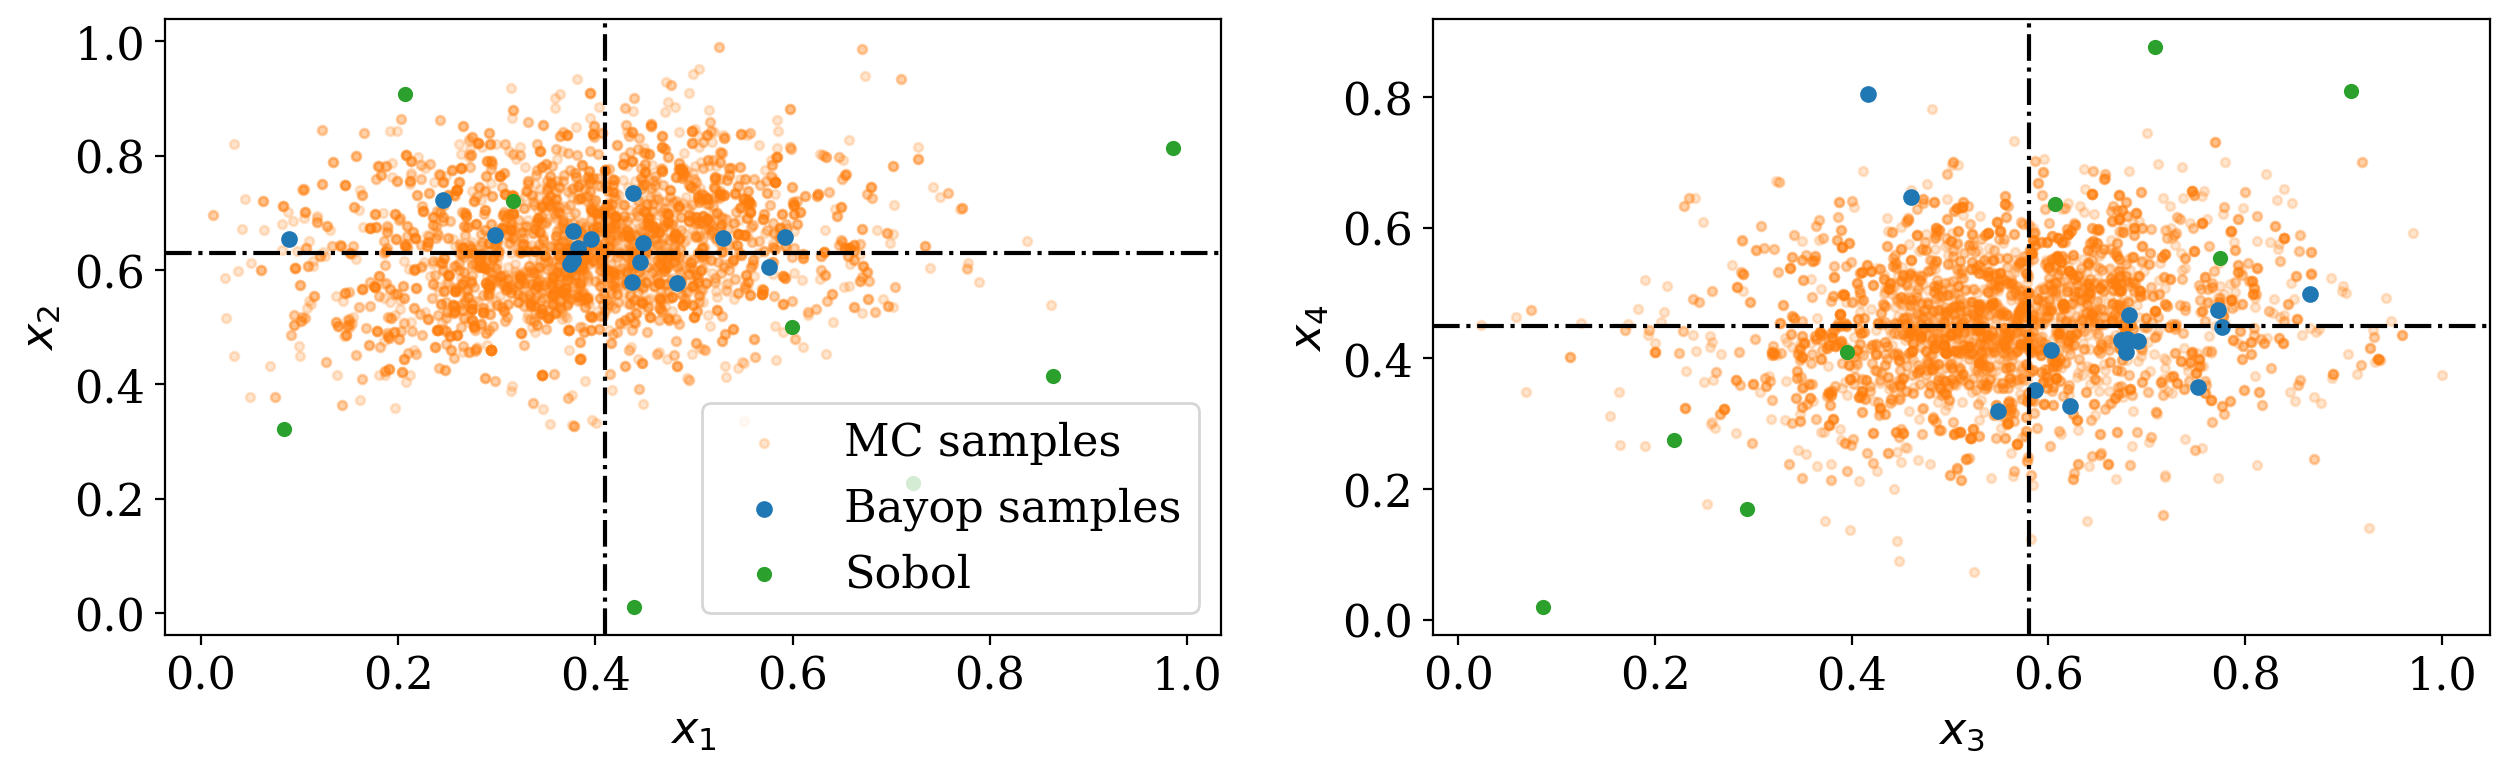

In [9]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(15,4))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    x.axvline(f_mean[2*i],ls='-.',color='k')
    x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()

In [10]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=3000,difficult_model=True)
print(f"LogZ info: "+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 6.44s
INFO:[NS]: jaxns did 380559 likelihood evaluations


LogZ info: logz_mean: = -0.0026, dlogz: = 0.1461, 


Removed no burn in
Removed no burn in


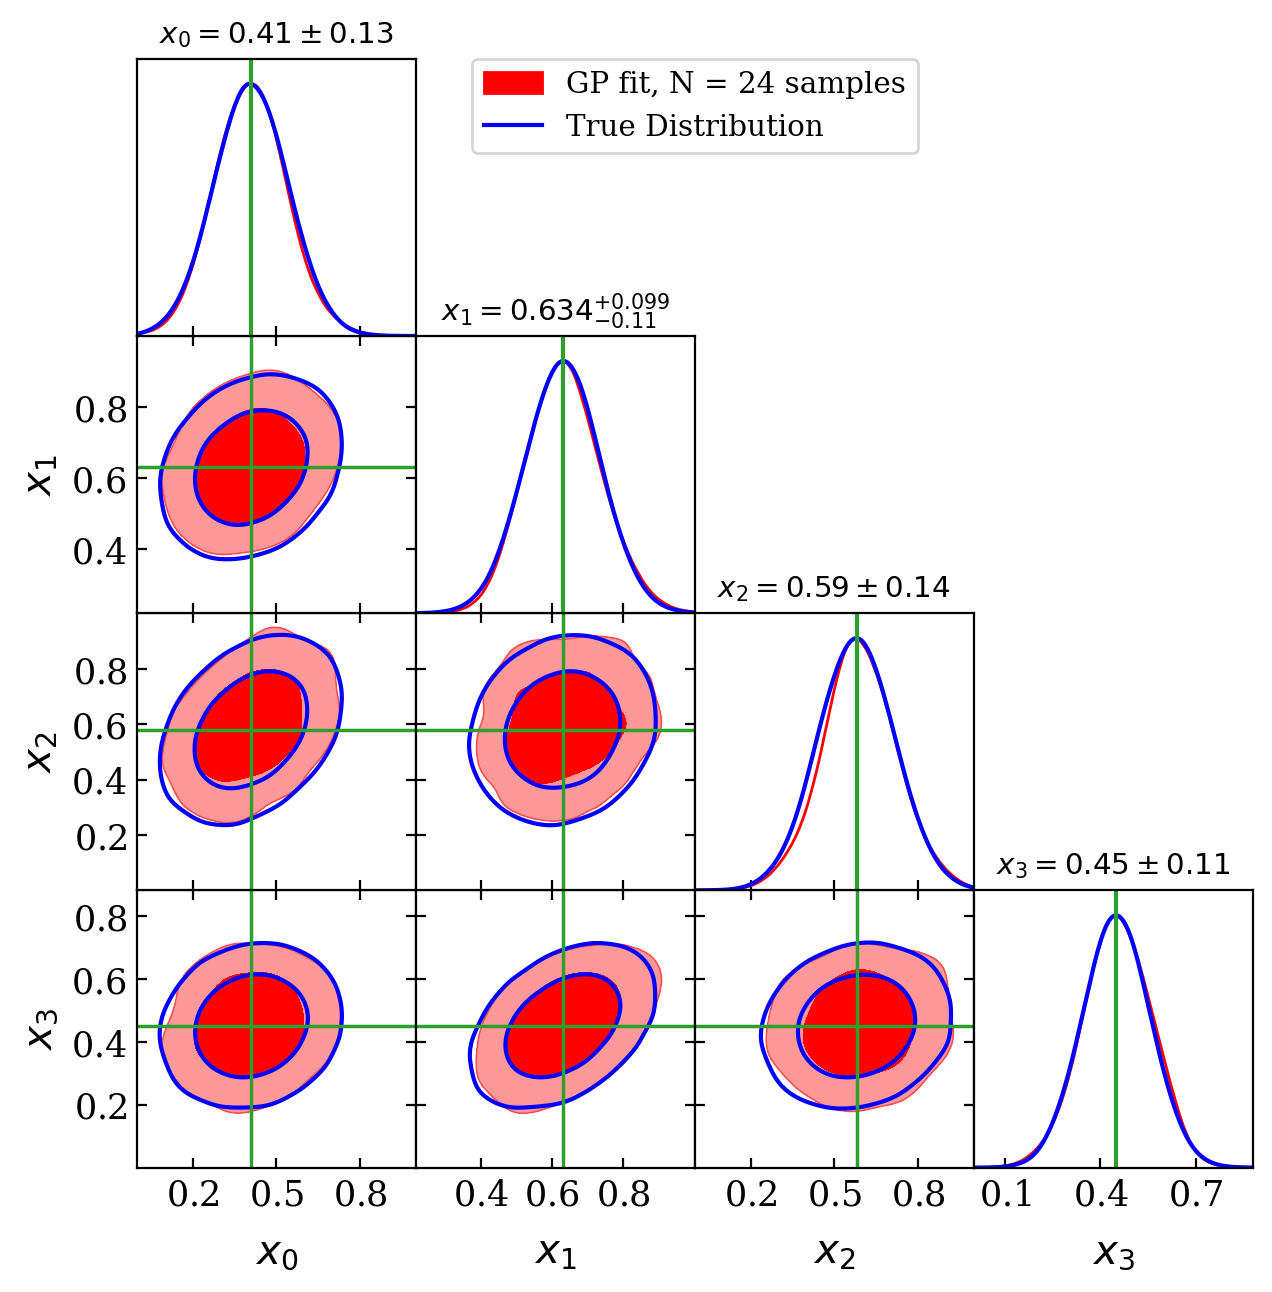

In [11]:
test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=test_samples,names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=1.8,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} samples','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-')

# for ax in g.subplots[:,0]:
#     ax.axvline(, color='C2', ls='-')
# IPython.display.display(g.fig)

